## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import graphviz
from IPython.display import SVG
from IPython.display import display
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer, classification_report, roc_auc_score
import sqlite3
import datetime
import scikitplot as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from gensim.models import Word2Vec
import spacy

from sklearn.externals.joblib import parallel_backend
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings('ignore')
global_start = datetime.datetime.now()

## Read Data into Pandas Dataframe

In [2]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
conn.close()

print('Shape of our data : {}'.format(data.shape))
data.head(3)    

Shape of our data : (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


## Randomly Sample 100k points from 364k points

In [3]:
sample_data = data.sample(n=100000, random_state=42).reset_index(drop=True)
del data # To free up the RAM
print('shape of our sampled data : {}'.format(sample_data.shape))
print('\n Distribution of class label : \n{}'.format(sample_data['Score'].value_counts(normalize=True)))
sample_data.head(3)

shape of our sampled data : (100000, 11)

 Distribution of class label : 
positive    0.84356
negative    0.15644
Name: Score, dtype: float64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,474309,B003L1XMAA,A2BS25CMKABXK5,"Lela ""Lela""",4,4,positive,1309996800,Delicious,Too busy enjoying this wonderful lavender extr...,busy enjoying wonderful lavender extract homem...
1,474247,B005IU1NLC,A1OTUKJ8298TY5,Elizabeth MccArthy,0,0,positive,1317600000,So yummy,These are sooooo good! I had to find them on h...,sooooo good find since sell single packet supe...
2,343379,B00004RBDU,A28ZA79VMCI8W1,"Linda Khan ""kittykatkhan""",2,2,positive,1257206400,Flea Trap WORKS!,"In the past, I have used a metal type flea tra...",past used metal type flea trap owned operated ...


## Time Based Splitting
We arrange the sampled data in ascending order of Time column and split the data without shuffling such that:

* Train_data = First 70%
* Test_data = Last 30%

In [4]:
# Sort by Time
sample_data = sample_data.sort_values('Time').reset_index(drop=True)

X_text = sample_data.iloc[:,10] # Selecting the 'CleanedText' column
y = sample_data.iloc[:,6] # Selecting the 'Score' column

# Split the data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_text_train : {}'.format(X_text_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_test : {}'.format(X_text_test.shape))
print('Shape of y_test : {}'.format(y_test.shape))

Shape of X_text_train : (70000,)
Shape of y_train : (70000,)

Shape of X_text_test : (30000,)
Shape of y_test : (30000,)


## Modelling
We will Create a **Logistic Regression** based classification model using the following features:

* Binary Bag Of Words 
* Count based Bag Of words 
* TFIDF 
* AVG Word2Vec
* TFIDF weighted Word2Vec

### Create Features
The function below will convert raw text to the designated features

In [33]:
def featurize(feature, standardize=True):
    
    if feature == 'binary_bow':
        count_vec = CountVectorizer(binary=True)
        X_train = count_vec.fit_transform(X_text_train)
        X_test = count_vec.transform(X_text_test)
        featurizer = count_vec
       
    if feature == 'bow':
        count_vec = CountVectorizer()
        X_train = count_vec.fit_transform(X_text_train)
        X_test = count_vec.transform(X_text_test)
        featurizer = count_vec
        
    if feature == 'tfidf':
        tfidf_vec = TfidfVectorizer()
        X_train = tfidf_vec.fit_transform(X_text_train)
        X_test = tfidf_vec.transform(X_text_test)
        featurizer = tfidf_vec
       
    if feature == 'w2v':
        X_train, X_test = get_w2v()
        featurizer = None
       
    if feature == 'tfidf_w2v':
        X_train, X_test = get_tfidf_w2v()
        featurizer = None
        
    if standardize:
        scaler = StandardScaler(with_mean=False)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, featurizer 

In [26]:
def get_w2v():
    
    # ******************* Tokenize training reviews ********************
    review_list = []
    for review in X_text_train:
        review_list.append(review.split())
        
    # ****************** Word2Vec **********************
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    
    # *************** Converting training reviews to vectors ********************
    X_train = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                review_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            review_vec /= cnt_words
        X_train.append(review_vec)
    X_train = np.array(X_train)
    
    # ********** Tokenize test reviews *****************
    review_list = []
    for review in X_text_test:
        review_list.append(review.split())
        
    # **************** Converting test reviews to vectors ****************
    X_test = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                review_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            review_vec /= cnt_words
        X_test.append(review_vec)
    X_test = np.array(X_test)
    
    return X_train, X_test

In [25]:
def get_tfidf_w2v():
    
    # ******************* Tokenize training reviews ********************
    review_list = []
    for review in X_text_train:
        review_list.append(review.split())
        
    # ********************** Word2Vec**************************
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)    
    
    # *********************** TF-IDF **************************
    tfidf_vec = TfidfVectorizer()
    tfidf_vec.fit(X_text_train)
    idf_dict = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))
    
    # ***************** Converting Training Reviews to vectors *************
    X_train = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                tf_idf = idf_dict[word]*(review.count(word)/len(review))
                review_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            review_vec /= weight_sum
        X_train.append(review_vec)
    X_train = np.array(X_train)
    
    # ********** Tokenize test reviews *****************
    review_list = []
    for review in X_text_test:
        review_list.append(review.split())
       
    # ****************** Converting Test reviews to vectors *************
    X_test = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                tf_idf = idf_dict[word]*(review.count(word)/len(review))
                review_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            review_vec /= weight_sum
        X_test.append(review_vec)
    X_test = np.array(X_test)
   
    return X_train, X_test

### Cross validation and Hyper Parameter turning using GridSearch

In [34]:
def cross_val():
    
    start = datetime.datetime.now()
    
    # Create a DT object
    clf = DecisionTreeClassifier(class_weight='balanced')
    
    # Tune hyper parameters using grid search
    param_dict = {}
    param_dict['max_depth'] = [1, 5, 10, 50, 100]
    param_dict['min_samples_split'] = [5, 10, 100, 500]
    model = GridSearchCV(clf, param_grid=param_dict, scoring='roc_auc', cv=2, n_jobs=-1, verbose=10)
    model.fit(X_train, y_train)
    
    
    print('\nTime taken for cross-validation : {}'.format(datetime.datetime.now() - start))
    print("\nBest model found using cross-validation : {}".format(model.best_estimator_))
    print('\nAUC score of the best model using cross-validation : {}'.format(model.best_score_))

        
    return model.best_estimator_
    

### Plot Feature Importance

In [35]:
def plot_feature_importance():
    if featurizer is not None:
        skplt.estimators.plot_feature_importances(clf, feature_names=featurizer.get_feature_names(), 
                                                  max_num_features=20, figsize=(15,6), x_tick_rotation=45)

### Visualize The Tree

In [36]:
def plot_tree():
    if featurizer is not None:
        dot_data = export_graphviz(clf, out_file=None, 
                                    max_depth = 2,
                         feature_names = featurizer.get_feature_names(),  
                         class_names=clf.classes_,  
                         filled=True, rounded=True,  
                         special_characters=True)  

        graph = graphviz.Source(dot_data)  
        display(SVG(graph.pipe(format='svg')))

### Predictions on Test Data 

In [43]:
def make_predictions(clf):
    
    y_pred = clf.predict(X_test)
    y_scores = clf.predict_proba(X_test)
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA ##########')
    print('\n\taccuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print('\tMicro f1-score on test data : {}'.format(f1_score(y_test, y_pred, average='micro')))
    print('\tAUC score on test data : {}'.format(roc_auc_score(y_test, y_scores[:,1])))
    print()
    print(classification_report(y_test, y_pred))
    print()
    print()
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_roc(y_test, y_scores)

## Bag Of Words

In [14]:
X_train, X_test, featurizer = featurize('bow', standardize=False)

In [15]:
clf = cross_val()

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.8min remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished



Time taken for cross-validation : 0:01:59.573237

Best model found using cross-validation : DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

AUC score of the best model using cross-validation : 0.7982552156682355


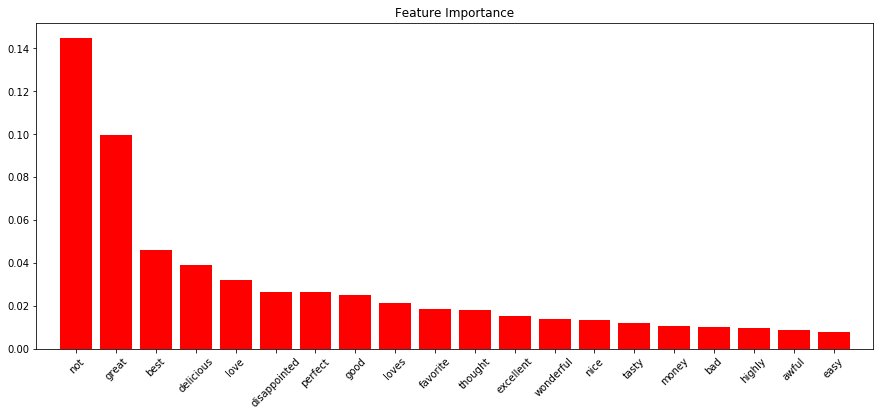

In [16]:
plot_feature_importance()

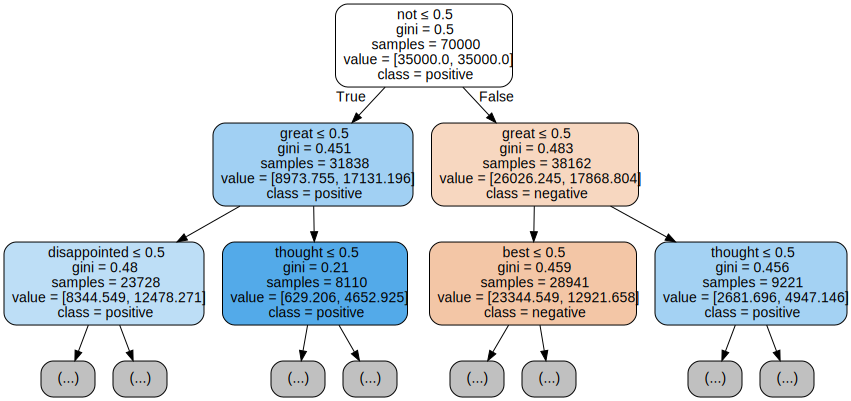

In [17]:
plot_tree()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7441666666666666
	Micro f1-score on test data : 0.7441666666666665
	AUC score on test data : 0.8249905826284739

              precision    recall  f1-score   support

    negative       0.39      0.78      0.52      5242
    positive       0.94      0.74      0.83     24758

   micro avg       0.74      0.74      0.74     30000
   macro avg       0.66      0.76      0.67     30000
weighted avg       0.84      0.74      0.77     30000





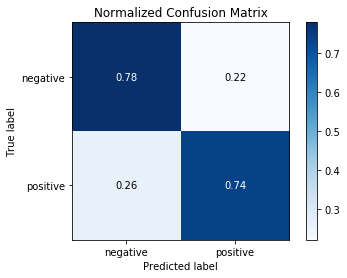

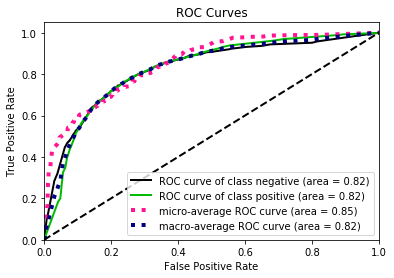

In [18]:
make_predictions(clf)

## TF-IDF

In [19]:
X_train, X_test, featurizer = featurize('tfidf', standardize=False)

In [20]:
clf = cross_val()

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  3.2min remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.2min finished



Time taken for cross-validation : 0:03:32.317950

Best model found using cross-validation : DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

AUC score of the best model using cross-validation : 0.7971835414433662


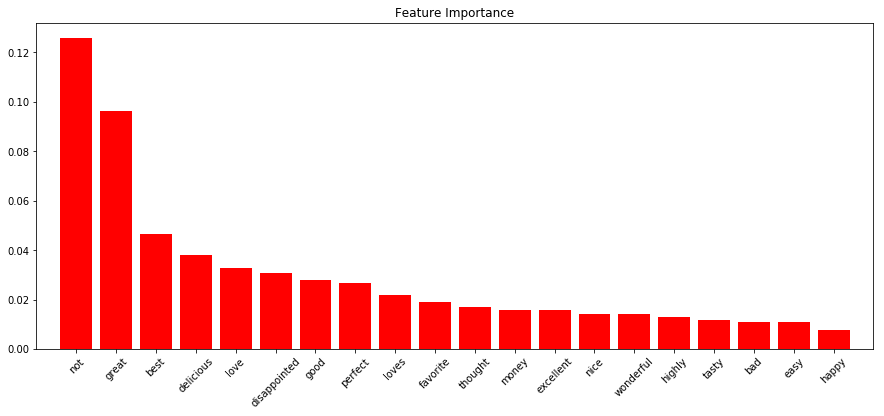

In [21]:
plot_feature_importance()

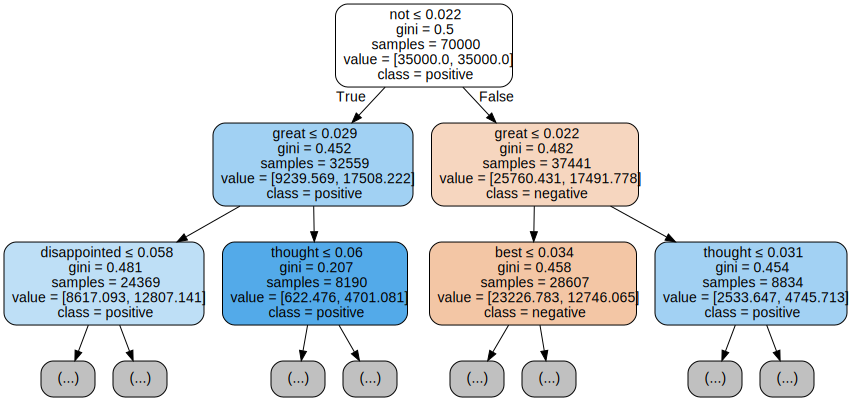

In [22]:
plot_tree()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7442333333333333
	Micro f1-score on test data : 0.7442333333333333
	AUC score on test data : 0.8203016839789012

              precision    recall  f1-score   support

    negative       0.38      0.77      0.51      5242
    positive       0.94      0.74      0.83     24758

   micro avg       0.74      0.74      0.74     30000
   macro avg       0.66      0.76      0.67     30000
weighted avg       0.84      0.74      0.77     30000





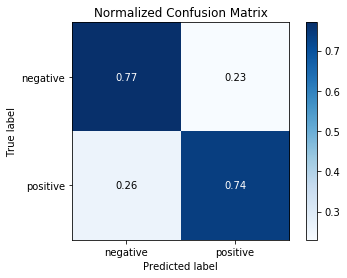

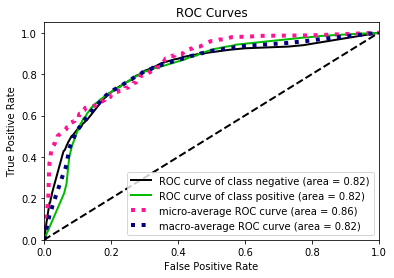

In [23]:
make_predictions(clf)

## Average Word2Vec

In [28]:
X_train, X_test, featurizer = featurize('w2v', standardize=False)
clf = cross_val()

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:   41.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   41.7s finished



Time taken for cross-validation : 0:00:46.666136

Best model found using cross-validation : DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

AUC score of the best model using cross-validation : 0.8094469131736115



########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7185
	Micro f1-score on test data : 0.7185
	AUC score on test data : 0.8185806366019868

              precision    recall  f1-score   support

    negative       0.36      0.77      0.49      5242
    positive       0.94      0.71      0.81     24758

   micro avg       0.72      0.72      0.72     30000
   macro avg       0.65      0.74      0.65     30000
weighted avg       0.84      0.72      0.75     30000





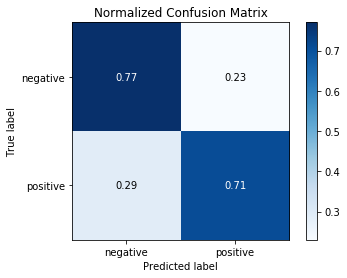

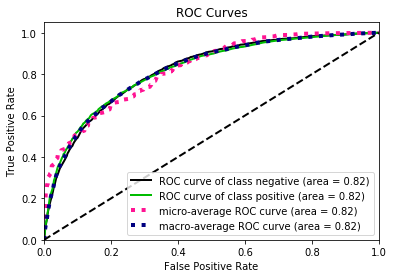

In [29]:
make_predictions(clf)

## TF-IDF Weighted Word2vec

In [30]:
X_train, X_test, featurizer = featurize('tfidf_w2v', standardize=False)
clf = cross_val()

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:   41.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   41.1s finished



Time taken for cross-validation : 0:00:46.955291

Best model found using cross-validation : DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

AUC score of the best model using cross-validation : 0.780342816514304



########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7155333333333334
	Micro f1-score on test data : 0.7155333333333334
	AUC score on test data : 0.7887123663818916

              precision    recall  f1-score   support

    negative       0.35      0.71      0.47      5242
    positive       0.92      0.72      0.81     24758

   micro avg       0.72      0.72      0.72     30000
   macro avg       0.63      0.71      0.64     30000
weighted avg       0.82      0.72      0.75     30000





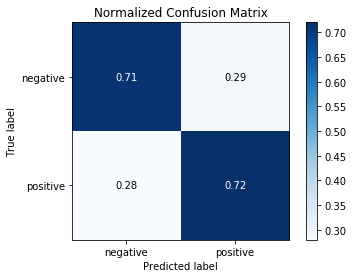

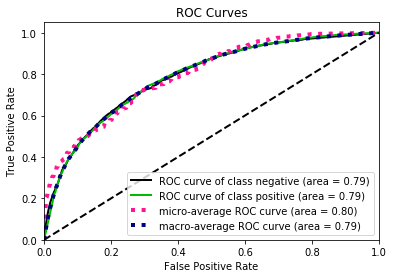

In [31]:
make_predictions(clf)

## Create new feature by repeating the summary thrice with the text

In [30]:
def repeat_summary(row):
    
    summary = str(row[8])
    text = str(row[10])
    
    new_text = summary + " " + summary + " " + summary + " " + text
    return new_text

In [31]:
# Read the data
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)

# sample 100k points
sample_data = data.sample(n=100000, random_state=42).reset_index(drop=True)

# FREE THE RAM
del data

# add the new_text column
sample_data['new_text'] = sample_data.apply(repeat_summary, axis=1)

# Sort by Time
sample_data = sample_data.sort_values('Time').reset_index(drop=True)

X_text = sample_data.iloc[:,11] # Selecting the 'new_text' column
y = sample_data.iloc[:,6] # Selecting the 'Score' column

# Split the data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_text_train : {}'.format(X_text_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_test : {}'.format(X_text_test.shape))
print('Shape of y_test : {}'.format(y_test.shape))

Shape of X_text_train : (70000,)
Shape of y_train : (70000,)

Shape of X_text_test : (30000,)
Shape of y_test : (30000,)


## Bag of Words On new feature

In [38]:
X_train, X_test, featurizer = featurize('bow', standardize=False)

In [39]:
clf = cross_val()

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.6min remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.6min finished



Time taken for cross-validation : 0:01:50.992751

Best model found using cross-validation : DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

AUC score of the best model using cross-validation : 0.8538618521057051


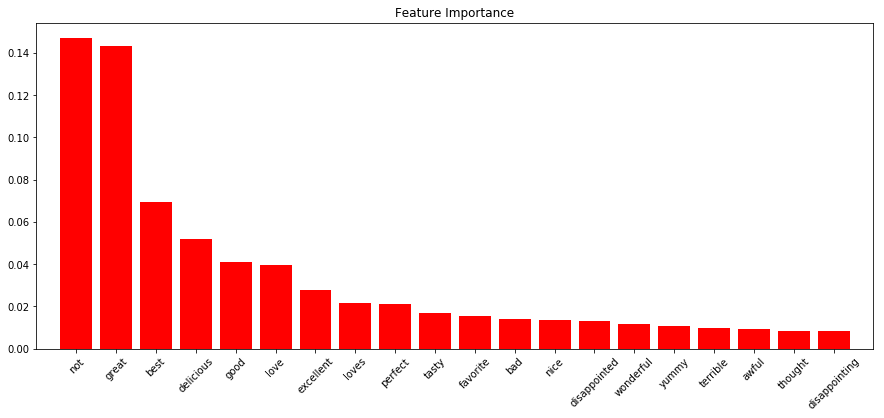

In [40]:
plot_feature_importance()

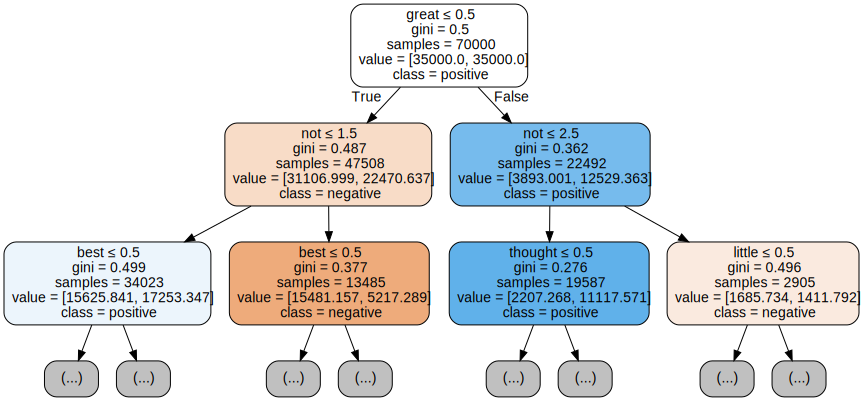

In [41]:
plot_tree()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8068333333333333
	Micro f1-score on test data : 0.8068333333333333
	AUC score on test data : 0.8783499244067542

              precision    recall  f1-score   support

    negative       0.47      0.82      0.60      5242
    positive       0.96      0.80      0.87     24758

   micro avg       0.81      0.81      0.81     30000
   macro avg       0.71      0.81      0.74     30000
weighted avg       0.87      0.81      0.82     30000





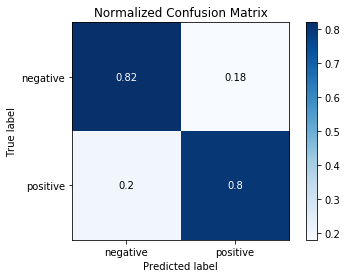

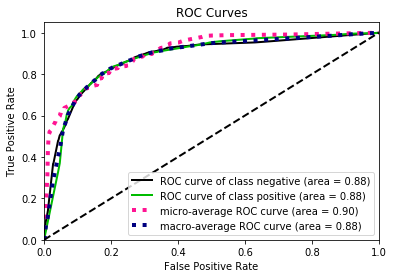

In [44]:
make_predictions(clf)

## Conclusions

In [7]:
x = PrettyTable()
x.field_names = ['Model', 'Accuracy', 'AUC_score', 'F1-score']
x.add_row(['Bag of Words', 0.74, 0.82, 0.74])
x.add_row(['TF-IDF', 0.74, 0.82, 0.74])
x.add_row(['Avg_W2V', 0.72, 0.82, 0.72])
x.add_row(['TFIDF_W2V', 0.72, 0.78, 0.72])
x.add_row(['Feature Engineering + BOW', 0.81, 0.88, 0.81])
print(x)

+---------------------------+----------+-----------+----------+
|           Model           | Accuracy | AUC_score | F1-score |
+---------------------------+----------+-----------+----------+
|        Bag of Words       |   0.74   |    0.82   |   0.74   |
|           TF-IDF          |   0.74   |    0.82   |   0.74   |
|          Avg_W2V          |   0.72   |    0.82   |   0.72   |
|         TFIDF_W2V         |   0.72   |    0.78   |   0.72   |
| Feature Engineering + BOW |   0.81   |    0.88   |   0.81   |
+---------------------------+----------+-----------+----------+
